<a href="https://colab.research.google.com/github/Amoghkori/steganography/blob/main/stegonography_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np
import tensorflow.compat.v1 as tf # Ensure TF2 compatability
tf.disable_v2_behavior()
import keras
from keras.models import Model
from keras.layers import Dense, Input, concatenate, Conv2D, GaussianNoise
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import load_model
#from keras.utils import multi_gpu_model
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import imageio
from io import StringIO, BytesIO#
import tensorflow as tf1

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
os.mkdir('/content/cover_image')
os.mkdir('/content/cover_image_val')
os.mkdir('/content/secret_image')
os.mkdir('/content/secret_image_val')

In [ ]:
cp -r '/content/drive/MyDrive/new cover image' /content/cover_image

In [ ]:
cp -r '/content/drive/MyDrive/new cover_val' /content/cover_image_val

In [ ]:
cp -r '/content/drive/MyDrive/secret image mix' /content/secret_image

In [ ]:
cp -r '/content/drive/MyDrive/secret mix val' /content/secret_image_val

In [ ]:
COVER_TRAIN="/content/cover_image"
SECRET_TRAIN="/content/secret_image"
COVER_VALIDATION="/content/cover_image_val"
SECRET_VALIDATION= "/content/secret_image_val"
TRAIN_NUM=len(glob.glob(COVER_TRAIN+"/*/*"))
VAL_NUM=len(glob.glob(COVER_VALIDATION+"/*/*"))
COVER_TEST_DATA="/content/drive/MyDrive/cover_test.npz"
SECRET_TEST_DATA="/content/drive/MyDrive/secret_test.npz"

In [ ]:
TRAIN_NUM

500

In [ ]:
VAL_NUM

250

In [ ]:
CHECKPOINT="/content/drive/MyDrive/models_mix/steg_model-{epoch:02d}-{val_loss:.2f}.hdf5"

In [ ]:
BATCH_SIZE=12

In [ ]:
test_cover_images=np.load(COVER_TEST_DATA)['arr_0']
test_secret_images=np.load(SECRET_TEST_DATA)['arr_0']

In [ ]:
tsecret = test_secret_images[0].reshape((1,224,224,3))
tcover = test_cover_images[1].reshape((1,224,224,3))

In [ ]:
def normalize_batch(imgs):
    '''Performs channel-wise z-score normalization'''

    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])
                                                        
def denormalize_batch(imgs,should_clip=True):
    '''Denormalize the images for prediction'''

    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    
    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs


In [ ]:
input_imgen = ImageDataGenerator(rescale = 1./255)
test_imgen = ImageDataGenerator(rescale = 1./255)

In [ ]:
def generate_generator_multiple(generator, direc1,direc2):
    genX1 = generator.flow_from_directory(direc1, target_size=(224,224), batch_size = BATCH_SIZE, shuffle=True, seed=3, class_mode=None)
    genX2 = generator.flow_from_directory( direc2, target_size=(224, 224), batch_size = BATCH_SIZE, shuffle=True, seed=8, class_mode=None)
    
    while True:
            X1i = normalize_batch(genX1.next()) 
            X2i = normalize_batch(genX2.next())

            yield( {'secret': X1i, 'cover': X2i}, {'hide_conv_f': X2i, 'revl_conv_f': X1i}) 

In [ ]:
inputgenerator=generate_generator_multiple(generator=input_imgen, direc1=SECRET_TRAIN,direc2=COVER_TRAIN)

In [ ]:
testgenerator=generate_generator_multiple(test_imgen, direc1=SECRET_VALIDATION,direc2=COVER_VALIDATION)

In [ ]:
def custom_loss_1(secret,secret_pred):
    
    # Compute L2 loss(MSE) for secret image
    secret_mse = keras.losses.mean_squared_error(secret,secret_pred)
    return secret_mse

def custom_loss_2(cover,cover_pred):

    # Compute L2 loss(MSE) for cover image
    cover_mse = keras.losses.mean_squared_error(cover,cover_pred)
    return cover_mse 

In [ ]:
losses = {
	"hide_conv_f": custom_loss_2,
	"revl_conv_f": custom_loss_1,
}

# Loss weights
lossWeights = {"hide_conv_f": 1.0, "revl_conv_f": 0.75}

In [ ]:
tf.debugging.set_log_device_placement(True)

In [ ]:
def steg_model(pretrain=False):
    
    if(pretrain):
       model=load_model(PRETRAINED,custom_objects={'custom_loss_1': custom_loss_1, 'custom_loss_2': custom_loss_2})
       return model
    
    # Inputs
    secret = Input(shape=(224,224,3),name='secret')
    cover = Input(shape=(224,224,3),name='cover')

    # Prepare network - patches [3*3,4*4,5*5]
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_1')(secret)
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_2')(pconv_3x3)
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_3')(pconv_3x3)
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_4')(pconv_3x3)

    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_1')(secret)
    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_2')(pconv_4x4)
    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_3')(pconv_4x4)
    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_4')(pconv_4x4)

    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_1')(secret)
    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_2')(pconv_5x5)
    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_3')(pconv_5x5)
    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_4')(pconv_5x5)

    pconcat_1 = concatenate([pconv_3x3,pconv_4x4,pconv_5x5], axis=3, name="prep_concat_1")

    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_f')(pconcat_1)
    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_f')(pconcat_1)
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_f')(pconcat_1)

    pconcat_f1 = concatenate([pconv_5x5,pconv_4x4,pconv_3x3], axis=3, name="prep_concat_2")

    # Hiding network - patches [3*3,4*4,5*5]
    hconcat_h = concatenate([cover,pconcat_f1], axis=3, name="hide_concat_1")

    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_1')(hconcat_h)
    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_2')(hconv_3x3)
    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_3')(hconv_3x3)
    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_4')(hconv_3x3)

    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_1')(hconcat_h)
    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_2')(hconv_4x4)
    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_3')(hconv_4x4)
    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_4')(hconv_4x4)

    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_1')(hconcat_h)
    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_2')(hconv_5x5)
    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_3')(hconv_5x5)
    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_4')(hconv_5x5)

    hconcat_1 = concatenate([hconv_3x3,hconv_4x4,hconv_5x5], axis=3, name="hide_concat_2")

    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_f')(hconcat_1)
    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_f')(hconcat_1)
    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_f')(hconcat_1)

    hconcat_f1 = concatenate([hconv_5x5,hconv_4x4,hconv_3x3], axis=3, name="hide_concat_3")

    cover_pred = Conv2D(3, kernel_size=1, padding="same", name='hide_conv_f')(hconcat_f1)

    # Noise layer
    noise_ip = GaussianNoise(0.1)(cover_pred)

    # Reveal network - patches [3*3,4*4,5*5]
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_1')(noise_ip)
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_2')(rconv_3x3)
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_3')(rconv_3x3)
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_4')(rconv_3x3)

    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_1')(noise_ip)
    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_2')(rconv_4x4)
    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_3')(rconv_4x4)
    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_4')(rconv_4x4)

    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_1')(noise_ip)
    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_2')(rconv_5x5)
    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_3')(rconv_5x5)
    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_4')(rconv_5x5)

    rconcat_1 = concatenate([rconv_3x3,rconv_4x4,rconv_5x5], axis=3, name="revl_concat_1")

    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_f')(rconcat_1)
    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_f')(rconcat_1)
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_f')(rconcat_1)

    rconcat_f1 = concatenate([rconv_5x5,rconv_4x4,rconv_3x3], axis=3, name="revl_concat_2")

    secret_pred = Conv2D(3, kernel_size=1, padding="same", name='revl_conv_f')(rconcat_f1)

    model = Model(inputs=[secret, cover], outputs=[cover_pred, secret_pred])
  
    # Multi GPU training  (Uncomment the following line)
    #model = multi_gpu_model(model, gpus=2)

    # Compile model
    model.compile(optimizer='adam', loss=losses, loss_weights=lossWeights)

    return model

In [ ]:
model = steg_model(pretrain=False)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
secret (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
prep_conv3x3_1 (Conv2D)         (None, 224, 224, 50) 1400        secret[0][0]                     
__________________________________________________________________________________________________
prep_conv4x4_1 (Conv2D)         (None, 224, 224, 50) 2450        secret[0][0]                     
__________________________________________________________________________________________________
prep_conv5x5_1 (Conv2D)         (None, 224, 224, 50) 3800        secret[0][0]                     
______________________________________________________________________________________________

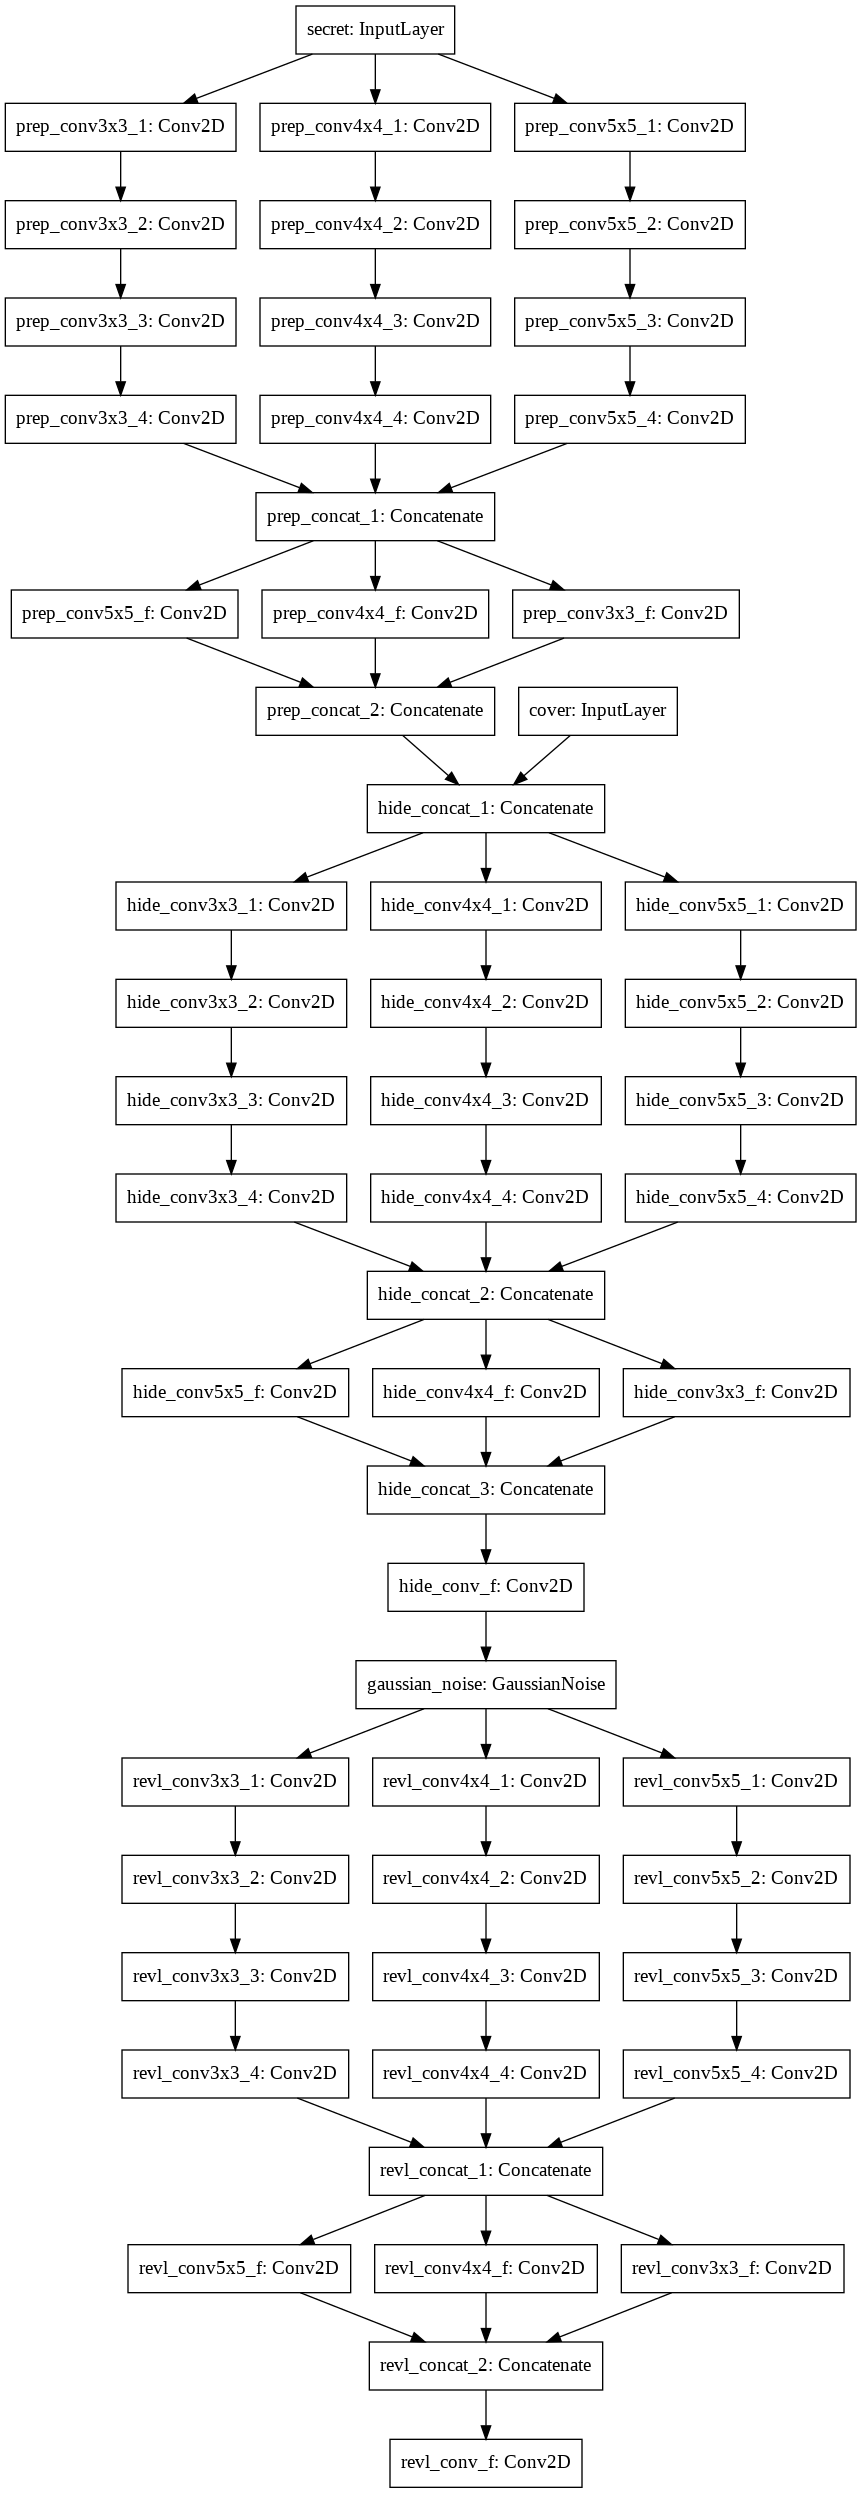

In [ ]:
plot_model(model, to_file='steg_model.png')

In [ ]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=True)
   
# TF file writer for images 
im_writer = tf.summary.FileWriter('/content/drive/MyDrive/models_mix/logs/im')
 
# TF image logger 
def log_images(tag, images, step):
     """Logs a list of images."""

     im_summaries = []
     for nr, img in enumerate(images):
            
            # Write the image to a string
            s = BytesIO()
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            im_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, nr),
                                                 image=img_sum))

     # Create and write Summary
     summary = tf.Summary(value=im_summaries)
     im_writer.add_summary(summary, step)

# Custom keras image callback
class TensorBoardImage(Callback):
    def __init__(self, tag):
        super().__init__() 
        self.tag = tag

    def on_epoch_end(self, epoch, logs={}):

        # Load random test images        
        secretin = test_secret_images[np.random.choice(len(test_secret_images), size=4, replace=False)]
        coverin = test_cover_images[np.random.choice(len(test_cover_images), size=4, replace=False)]
        
        # Predict on batch
        coverout, secretout=model.predict([normalize_batch(secretin),normalize_batch(coverin)])

        # Postprocess output cover image
        coverout = denormalize_batch(coverout)
        coverout=np.squeeze(coverout)*255.0
        coverout=np.uint8(coverout)
        
        # Postprocess output secret image
        secretout=denormalize_batch(secretout)
        secretout=np.squeeze(secretout)*255.0
        secretout=np.uint8(secretout)
        
        # Convert images to UINT8 format (0-255)
        coverin=np.uint8(np.squeeze(coverin*255.0))
        secretin=np.uint8(np.squeeze(secretin*255.0))
        
        # Log image summary
        log_images("cover_in", coverin, epoch)
        log_images("secret_in", secretin, epoch)
        log_images("cover_out", coverout, epoch)
        log_images("secret_out", secretout, epoch)
        
        return


In [ ]:
image_summary = TensorBoardImage('Image Example')

In [ ]:
filepath=CHECKPOINT

# Callback functions
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False , save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.000001, verbose=1)
callbacks_list = [checkpoint, tensorboard, image_summary, reduce_lr]


In [ ]:
with tf.device('/GPU:0'):
  history=model.fit_generator(inputgenerator, epochs=100, 
                          steps_per_epoch = TRAIN_NUM//BATCH_SIZE,
                          validation_data=testgenerator, 
                          validation_steps=VAL_NUM//BATCH_SIZE,
                          use_multiprocessing=True, 
                          callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Epoch 1/100
41/41 [==============================] - ETA: 0s - batch: 20.0000 - size: 12.0000 - loss: 1.3338 - hide_conv_f_loss: 0.5597 - revl_conv_f_loss: 1.0322WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
Found 250 images belonging to 1 classes.
Found 250 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.57615, saving model to /content/drive/MyDrive/models_mix/steg_model-01-0.58.hdf5
41/41 [==============================] - 166s 3s/step - batch: 20.0000 - size: 12.0000 - loss: 1.3338 - hide_conv_f_loss: 0.5597 - revl_conv_f_loss: 1.0322 - val_loss: 0.5762 - val_hide_conv_f_loss: 0.2294 - val_revl_conv_f_loss: 0.4623
Epoch 2/100
41/41 [==============================] - ETA: 0s - batch: 20.0000 - size: 11.9024 - loss: 0.2987 - hide_conv_f_loss: 0.1573 - revl_conv_f_loss: 0.1886WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
Found 250 images belonging to 1 classes.
Found 250 images belonging to 1 classes.

Epoch 00002: val_loss improved from 0.57615 to 0.29729, saving model to /content/drive/MyDrive/models_mix/steg_model-02-0.30.hdf5
41/41 [==============================] - 130s 3s/step - batch: 20.0000 - size: 11.9024 - loss:

In [ ]:
import pandas as pd
df = pd.DataFrame(history.history)
df.to_csv("/content/drive/MyDrive/models_mix/model_history.csv",index=False)

NameError: ignored